In [1]:
import radarsimpy

print("`RadarSimPy` used in this example is version: " + str(radarsimpy.__version__))

`RadarSimPy` used in this example is version: 14.0.0


# FMCW Radar DoA Estimation

## Introduction

Direction of Arrival (DoA) estimation is a fundamental technique used in radar systems to determine the direction from which a signal or target is emanating. This technique is particularly valuable in applications like radar surveillance, target tracking, navigation, and communication systems. By accurately estimating the direction of arrival of incoming signals, radar systems can effectively locate and track objects of interest.

DoA estimation involves determining the angles at which signals impinge upon an array of receiving antennas. This can be accomplished through various methods, each with its own advantages and limitations. Some common techniques for DoA estimation include:

1. **Beamforming:** Beamforming involves combining signals received from different antennas in a way that enhances the desired signal coming from a specific direction while suppressing interference from other directions. This can provide a rough estimate of the DoA based on which antenna receives the strongest signal.

2. **MUSIC (MUltiple SIgnal Classification):** The MUSIC algorithm exploits the signal subspace and noise subspace of the received signals to estimate the DoA with high resolution. It identifies the angles corresponding to the peaks in the spatial spectrum, providing accurate localization even for closely spaced signals.

3. **ESPRIT (Estimation of Signal Parameters via Rotational Invariance Techniques):** ESPRIT is a high-resolution DoA estimation technique that relies on exploiting the rotational invariance property of the signal subspace. It is computationally efficient and provides precise estimates of DoA for both coherent and incoherent signals.

4. **Capon's Method:** Capon's Minimum Variance Distortionless Response (MVDR) beamformer minimizes the output power subject to a constraint on the output power at the desired direction. It offers improved performance in the presence of spatially colored noise and interference.

5. **Phase Comparison Monopulse:** This method uses the phase differences between the signals received by different antennas to determine the DoA. It is often used in tracking and navigation systems.

6. **Correlation Techniques:** Cross-correlation between the signals received by different antennas can provide an estimate of the phase difference, which corresponds to the DoA.

7. **Coherent Processing:** This involves maintaining phase coherence between transmitted and received signals to achieve accurate DoA estimation. Coherent processing requires synchronization between the transmitter and receiver.

DoA estimation plays a crucial role in enhancing the capabilities of radar systems, enabling them to accurately locate and track multiple targets, discriminate between closely spaced targets, and improve overall situational awareness. The choice of DoA estimation technique depends on factors like the accuracy required, computational complexity, noise environment, and system constraints.

[`RadarSimPy`](https://radarsimx.com/radarsimx/radarsimpy/) boasts a comprehensive collection of prevalent DoA algorithms and beamformers within its `processing` module. The following example adeptly showcases the practical application of these algorithms within the realm of a simulated Multiple-Input Multiple-Output (MIMO) Frequency-Modulated Continuous Wave (FMCW) radar scenario.

## Setup a MIMO FMCW Radar

Firstly, import the required modules from `radarsimpy`. `numpy` will also be needed in this example.


In [2]:
import numpy as np
from radarsimpy import Radar, Transmitter, Receiver

### MIMO Array Configuration

We configure a MIMO array with 2 transmitter channels and 64 receiver channels. The synthesized array is a 1 x 128 uniform linear array. The array layout is shown below.

> Note: The modulation is not considered here. Assume the 2 transmitters are orthogonal.


In [3]:
wavelength = 3e8 / 60.5e9

N_tx = 2
N_rx = 64

tx_channels = []
tx_channels.append(
    dict(
        location=(0, -N_rx / 2 * wavelength / 2, 0),
    )
)

tx_channels.append(
    dict(
        location=(0, wavelength * N_rx / 2 - N_rx / 2 * wavelength / 2, 0),
    )
)

rx_channels = []
for idx in range(0, N_rx):
    rx_channels.append(
        dict(
            location=(0, wavelength / 2 * idx - (N_rx - 1) * wavelength / 4, 0),
        )
    )

Create the radar model by using `RadarSimPy` framework.


In [4]:
tx = Transmitter(
    f=[61e9, 60e9],
    t=[0, 16e-6],
    tx_power=15,
    prp=40e-6,
    pulses=512,
    channels=tx_channels,
)

rx = Receiver(
    fs=20e6,
    noise_figure=8,
    rf_gain=20,
    load_resistor=500,
    baseband_gain=30,
    channels=rx_channels,
)

radar = Radar(transmitter=tx, receiver=rx)

_Plot the array layout_


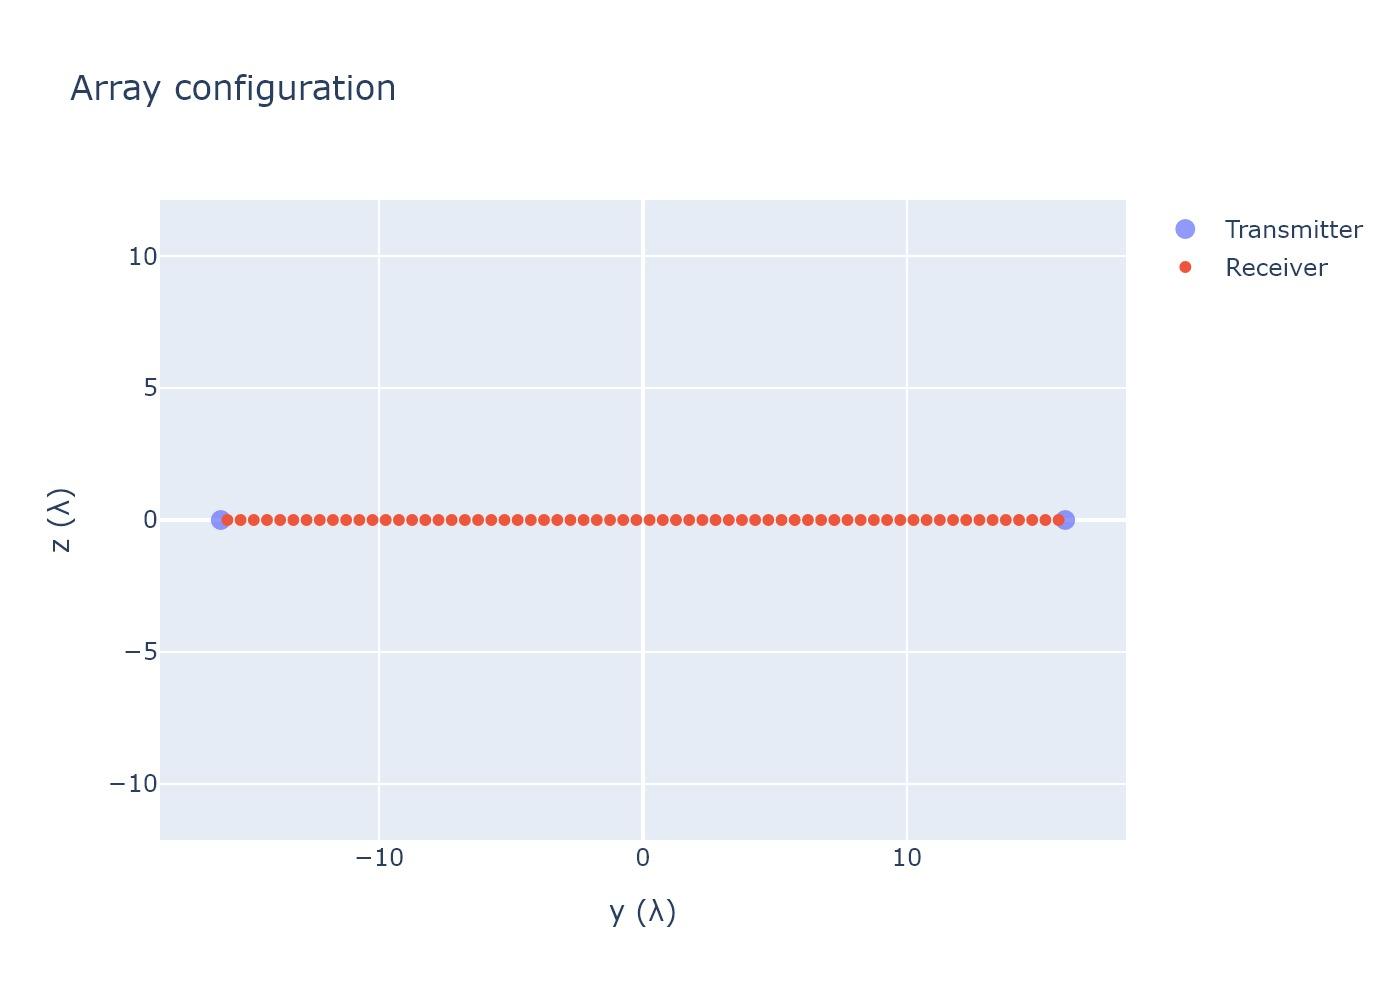

In [5]:
import plotly.graph_objs as go
from IPython.display import Image

fig = go.Figure()
fig.add_trace(
    go.Scatter(
        x=radar.radar_prop["transmitter"].txchannel_prop["locations"][:, 1]
        / wavelength,
        y=radar.radar_prop["transmitter"].txchannel_prop["locations"][:, 2]
        / wavelength,
        mode="markers",
        name="Transmitter",
        opacity=0.7,
        marker=dict(size=10),
    )
)

fig.add_trace(
    go.Scatter(
        x=radar.radar_prop["receiver"].rxchannel_prop["locations"][:, 1] / wavelength,
        y=radar.radar_prop["receiver"].rxchannel_prop["locations"][:, 2] / wavelength,
        mode="markers",
        opacity=1,
        name="Receiver",
    )
)

fig.update_layout(
    title="Array configuration",
    xaxis=dict(title="y (λ)"),
    yaxis=dict(title="z (λ)", scaleanchor="x", scaleratio=1),
)

# uncomment this to display interactive plot
# fig.show()

# display static image to reduce size on radarsimx.com
img_bytes = fig.to_image(format="jpg", scale=2)
display(Image(img_bytes))

## Targets

Create 3 targets at 40 m. The azimuth angles of the 3 targets are -5, -4, and 45 degrees relative to the radar.


In [6]:
true_theta = [-5, -4, 45]

target_1 = dict(
    location=(
        40 * np.cos(np.radians(true_theta[0])),
        40 * np.sin(np.radians(true_theta[0])),
        0,
    ),
    speed=(0, 0, 0),
    rcs=10,
    phase=0,
)
target_2 = dict(
    location=(
        40 * np.cos(np.radians(true_theta[1])),
        40 * np.sin(np.radians(true_theta[1])),
        0,
    ),
    speed=(0, 0, 0),
    rcs=10,
    phase=0,
)
target_3 = dict(
    location=(
        40 * np.cos(np.radians(true_theta[2])),
        40 * np.sin(np.radians(true_theta[2])),
        0,
    ),
    speed=(0, 0, 0),
    rcs=10,
    phase=0,
)

targets = [target_1, target_2, target_3]

## Simulate Baseband Signals

Use the `simulator.sim_radar` module to simulate the baseband samples from the defined radar system and targets.

The output baseband data is a dict including the timestamp and baseband. Both of them are 3-D matrix:

`[channels, pulses, ADC samples]`


In [7]:
from radarsimpy.simulator import sim_radar

data = sim_radar(radar, targets)
timestamp = data["timestamp"]
baseband = data["baseband"]+data["noise"]

## Range-Doppler Processing

Perform range-Doppler processing by using FFT across fast-time and slow-time data maps.


In [8]:
from scipy import signal
import radarsimpy.processing as proc

range_window = signal.windows.chebwin(radar.sample_prop["samples_per_pulse"], at=80)
doppler_window = signal.windows.chebwin(
    radar.radar_prop["transmitter"].waveform_prop["pulses"], at=60
)

range_doppler = proc.range_doppler_fft(baseband, rwin=range_window, dwin=doppler_window)

Find the beam vector of the peak and create the covariance matrix.


In [9]:
from scipy import linalg

det_idx = [np.argmax(np.mean(np.abs(range_doppler[:, 0, :]), axis=0))]

bv = range_doppler[:, 0, det_idx[0]]
bv = bv / linalg.norm(bv)

snapshots = 20

bv_snapshot = np.zeros((N_tx * N_rx - snapshots, snapshots), dtype=complex)

for idx in range(0, snapshots):
    bv_snapshot[:, idx] = bv[idx : (idx + N_tx * N_rx - snapshots)]

covmat = np.cov(bv_snapshot.conjugate())

FFT of the beam vector. Two peaks can be seen, and it is not able to discriminate the targets at -5 and -4 degrees.


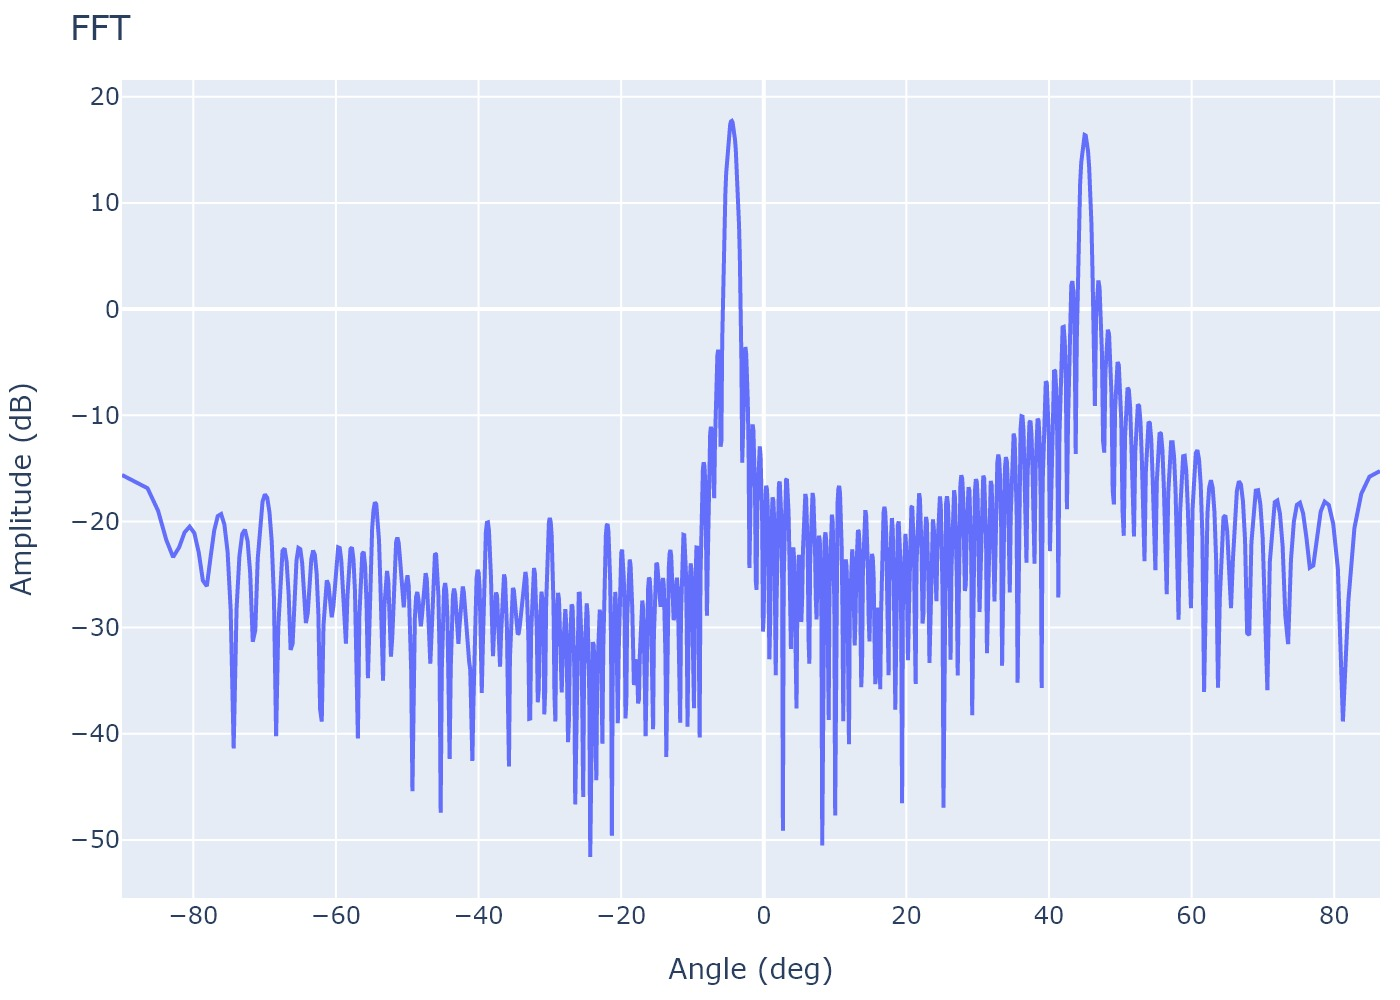

In [10]:
from scipy import fft

fft_spec = 20 * np.log10(np.abs(fft.fftshift(fft.fft(bv.conjugate(), n=1024))))

fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x=np.arcsin(np.linspace(-1, 1, 1024, endpoint=False)) / np.pi * 180,
        y=fft_spec,
        name="FFT",
    )
)

fig.update_layout(
    title="FFT",
    yaxis=dict(title="Amplitude (dB)"),
    xaxis=dict(title="Angle (deg)"),
    margin=dict(l=10, r=10, b=10, t=40),
)

# uncomment this to display interactive plot
# fig.show()

# display static image to reduce size on radarsimx.com
img_bytes = fig.to_image(format="jpg", scale=2)
display(Image(img_bytes))

### MUSIC


In [11]:
from radarsimpy.processing import doa_music

scan_angle = np.arange(-90, 90, 0.1)
music_doa, music_idx, ps_db = doa_music(covmat, 3, scanangles=scan_angle)

print("DoAs from MUSIC:", music_doa, "degrees")

DoAs from MUSIC: [-5.  -4.  45.1] degrees


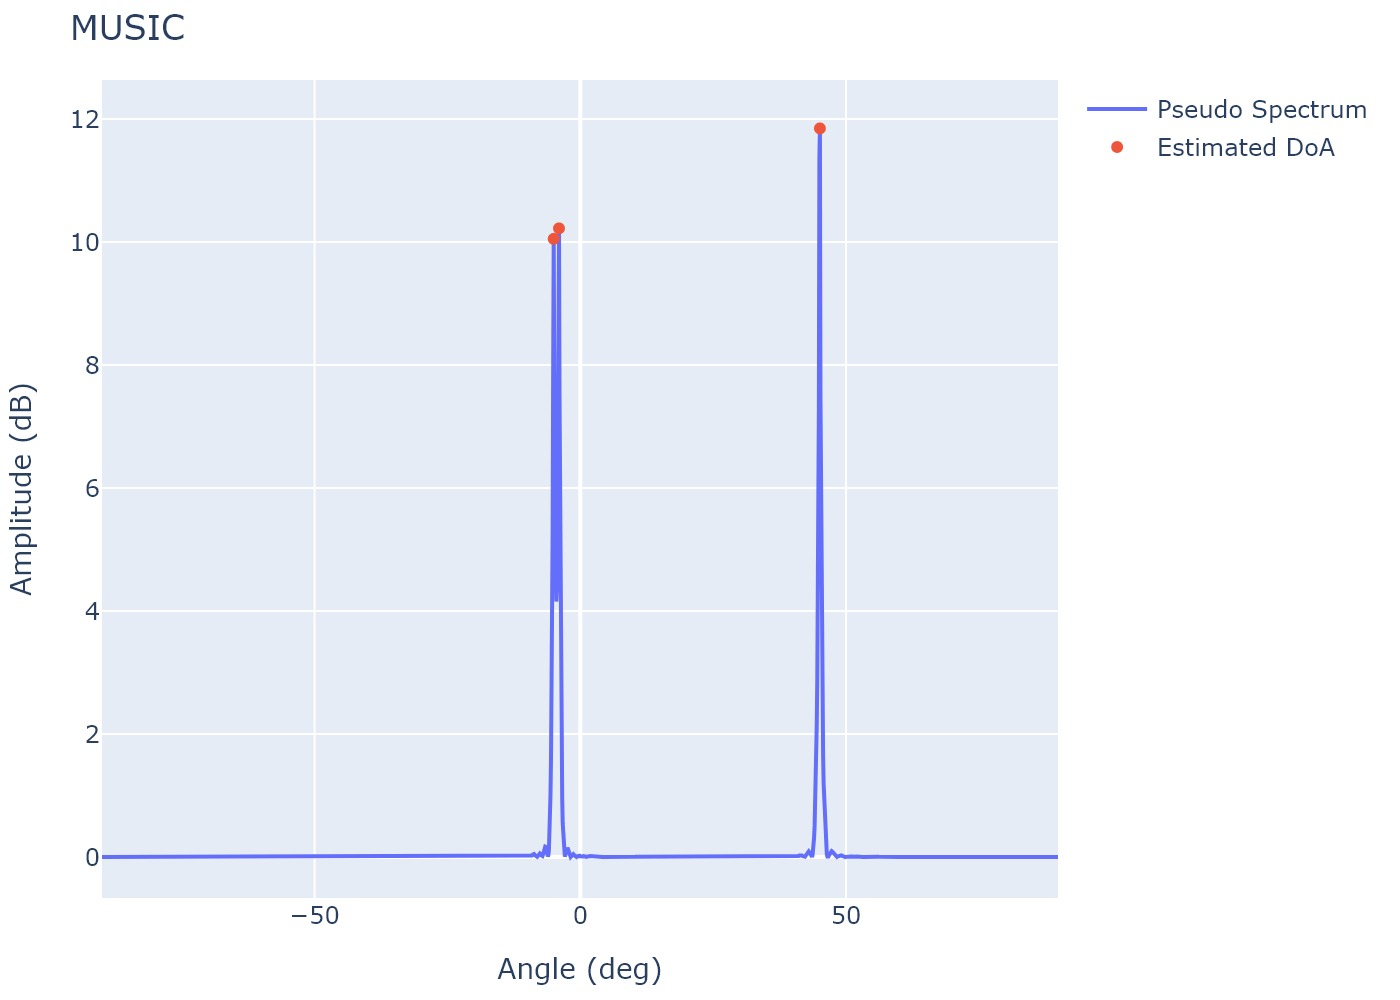

In [12]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=scan_angle, y=ps_db, name="Pseudo Spectrum"))

fig.add_trace(
    go.Scatter(x=music_doa, y=ps_db[music_idx], mode="markers", name="Estimated DoA")
)
fig.update_layout(
    title="MUSIC",
    yaxis=dict(title="Amplitude (dB)"),
    xaxis=dict(title="Angle (deg)"),
    margin=dict(l=10, r=10, b=10, t=40),
)

# uncomment this to display interactive plot
# fig.show()

# display static image to reduce size on radarsimx.com
img_bytes = fig.to_image(format="jpg", scale=2)
display(Image(img_bytes))

### Root-MUSIC


In [13]:
from radarsimpy.processing import doa_root_music

rootmusic_doa = doa_root_music(covmat, 3)
print("DoAs from Root-MUSIC:", rootmusic_doa, "degrees")

DoAs from Root-MUSIC: [45.05384367 -4.00659769 -5.00657405] degrees


### ESPRIT


In [14]:
from radarsimpy.processing import doa_esprit

esprit_doa = doa_esprit(covmat, 3)
print("DoAs from ESPRIT:", esprit_doa, "degrees")

DoAs from ESPRIT: [45.05326762 -4.01013595 -5.01071059] degrees


### IAA


In [15]:
from radarsimpy.processing import doa_iaa

azimuth = np.arange(-90, 90, 0.1)
array_loc = radar.array_prop["virtual_array"][:, 1] / wavelength

steering_vect = np.zeros((len(array_loc), len(azimuth)), dtype=complex)
for idx, d in enumerate(array_loc):
    steering_vect[idx, :] = np.exp(
        -1j * 2 * np.pi * (d * np.sin(azimuth / 180 * np.pi))
    )

spec_iaa = doa_iaa(bv, steering_vect)

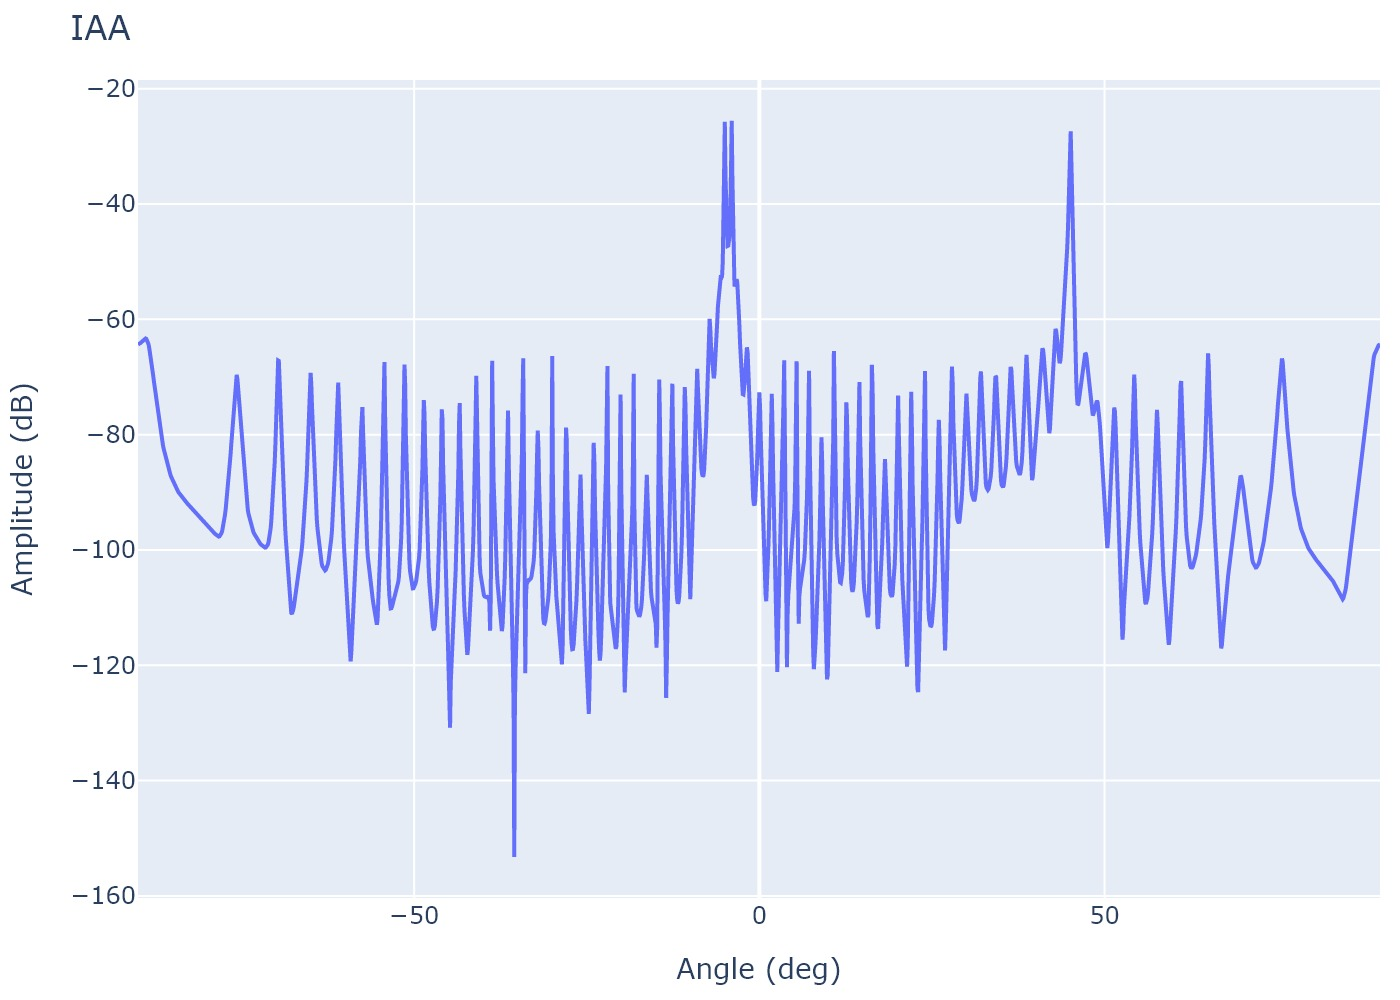

In [16]:
fig = go.Figure()

fig.add_trace(
    go.Scatter(x=azimuth, y=spec_iaa, name="Pseudo Spectrum")
)

fig.update_layout(
    title="IAA",
    yaxis=dict(title="Amplitude (dB)"),
    xaxis=dict(title="Angle (deg)"),
    margin=dict(l=10, r=10, b=10, t=40),
)

# uncomment this to display interactive plot
# fig.show()

# display static image to reduce size on radarsimx.com
img_bytes = fig.to_image(format="jpg", scale=2)
display(Image(img_bytes))

### Capon beamformer


In [17]:
from radarsimpy.processing import doa_capon

ps_capon = doa_capon(covmat, scanangles=scan_angle)

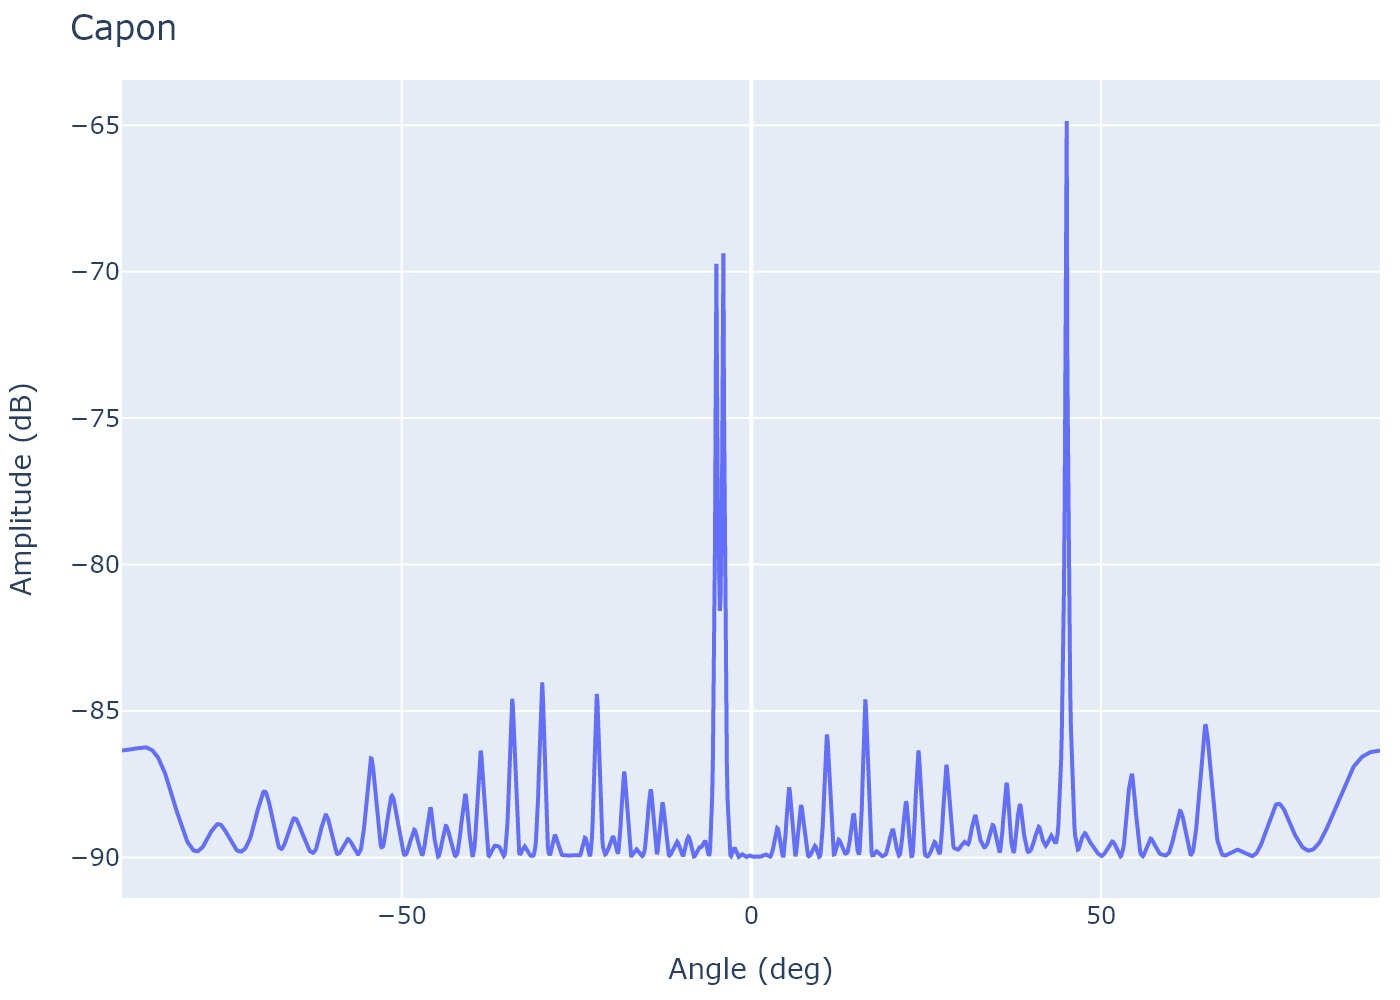

In [18]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=scan_angle, y=ps_capon, name="Pseudo Spectrum"))

fig.update_layout(
    title="Capon",
    yaxis=dict(title="Amplitude (dB)"),
    xaxis=dict(title="Angle (deg)"),
    margin=dict(l=10, r=10, b=10, t=40),
)

# uncomment this to display interactive plot
# fig.show()

# display static image to reduce size on radarsimx.com
img_bytes = fig.to_image(format="jpg", scale=2)
display(Image(img_bytes))

### Bartlett beamformer


In [19]:
from radarsimpy.processing import doa_bartlett

ps_bartlett = doa_bartlett(covmat, scanangles=scan_angle)

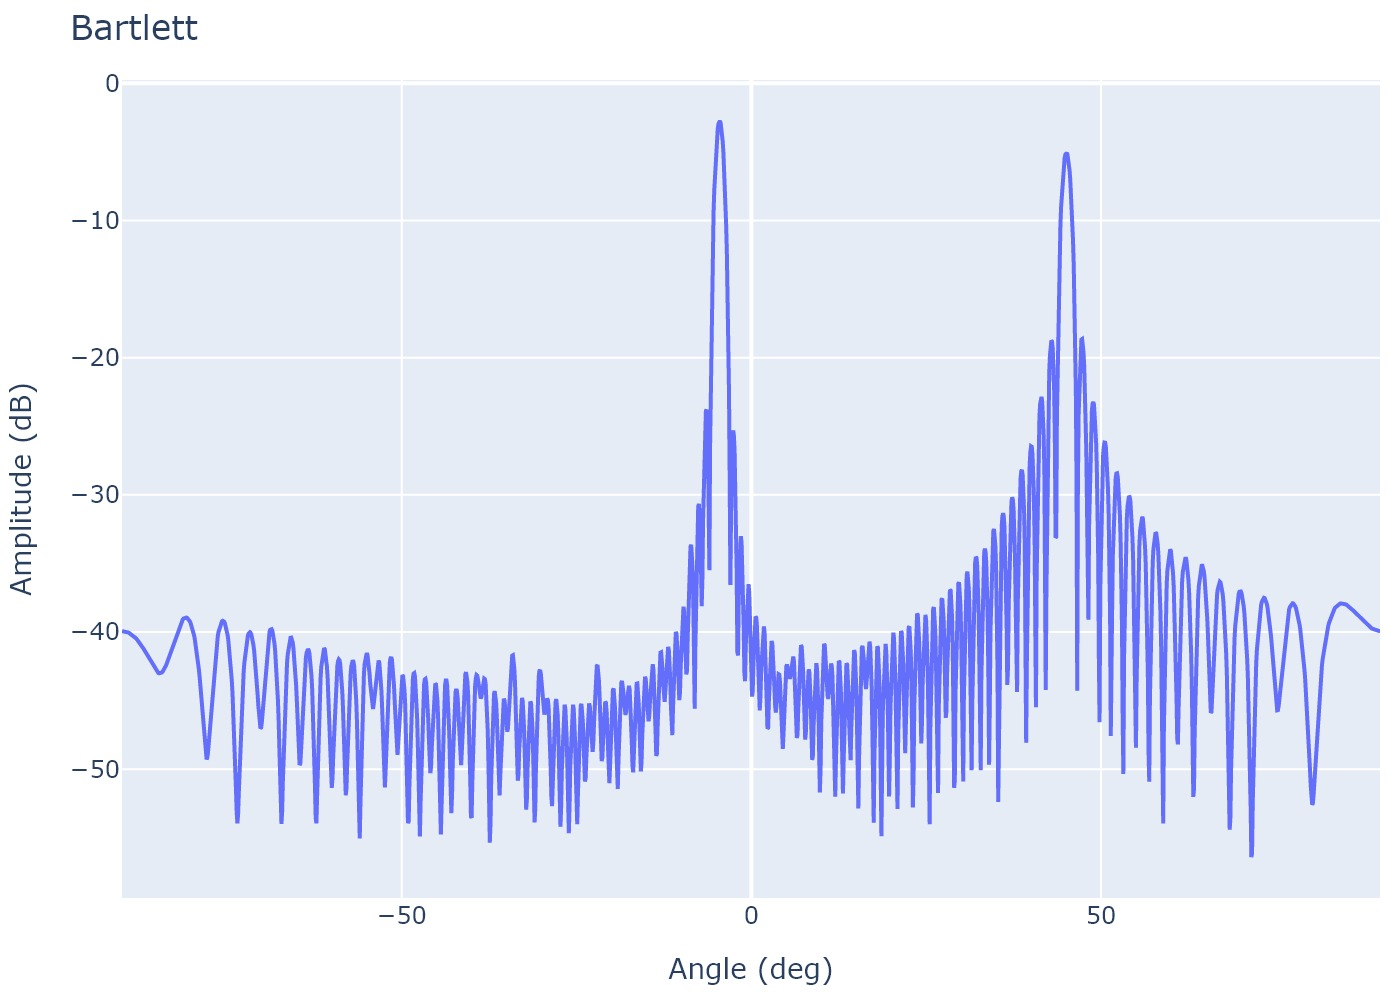

In [20]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=scan_angle, y=ps_bartlett, name="Pseudo Spectrum"))

fig.update_layout(
    title="Bartlett",
    yaxis=dict(title="Amplitude (dB)"),
    xaxis=dict(title="Angle (deg)"),
    margin=dict(l=10, r=10, b=10, t=40),
)

# uncomment this to display interactive plot
# fig.show()

# display static image to reduce size on radarsimx.com
img_bytes = fig.to_image(format="jpg", scale=2)
display(Image(img_bytes))